@ Authors:

BRUNO Daniele : https://github.com/dn-lo

FERZOLA Giusy : https://github.com/Giusy12

----------------------------------------------------------------

@ Original from:

LE BORGNE Pierre-Alexis :https://www.kaggle.com/pierra

GUILLAUME Florian : https://www.kaggle.com/florianguillaume


In [13]:
#Importing librairies

import pandas as pd 
import numpy as np

# Scikit-learn library: For SVM
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm

import itertools

# Matplotlib library to plot the charts
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Library for the statistic data vizualisation
import seaborn

%matplotlib inline



# Data recuperation

In [14]:
data = pd.read_csv('dataset/steel_plates_faults_raw.csv', sep="\t", header=None) # Reading the file .csv
df = pd.DataFrame(data) # Converting data to Panda DataFrame

title = pd.read_csv('dataset/steel_plates_faults_var.csv', sep="\t", index_col=None, header=None) # Reading the title .csv
dt = pd.DataFrame(title) # Converting data to Panda DataFrame
dt = dt.T

header = dt.values.tolist()

# data = pd.read_csv('dataset/steel_plates_faults.csv', sep="\t") # Reading the file .csv
# df = pd.DataFrame(data) # Converting data to Panda DataFrame

df.columns = header

# Data Visualization

In [15]:


Class_names = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']
X = df.drop(Class_names,axis=1) # Features
Y = df[Class_names] #Classes

X.describe() # Description of statistic features (Sum, Average, Variance, minimum, 1st quartile, 2nd quartile, 3rd Quartile and Maximum)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.033361,0.610529,0.813472,0.575734,2.492388,1.335686,1.403271,0.083288,-0.131305,0.585420
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.058961,0.243277,0.234274,0.482352,0.788930,0.481612,0.454345,0.500868,0.148767,0.339452
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,0.001500,0.014400,0.048400,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.998900,0.119000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,0.006600,0.411800,0.596800,0.000000,1.924300,1.000000,1.079200,-0.333300,-0.195000,0.248200
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.010100,0.636400,0.947400,1.000000,2.240600,1.176100,1.322200,0.095200,-0.133000,0.506300
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.023500,0.800000,1.000000,1.000000,2.914900,1.518500,1.732400,0.511600,-0.066600,0.999800
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.875900,1.000000,1.000000,1.000000,5.183700,3.074100,4.258700,0.991700,0.642100,1.000000


**Unbalanced data**

Number of plates with defect Pastry is 158
Number of plates with defect Z_Scratch is 190
Number of plates with defect K_Scatch is 391
Number of plates with defect Stains is 72
Number of plates with defect Dirtiness is 55
Number of plates with defect Bumps is 402
Number of plates with defect Other_Faults is 673


(0.0, 10.0)

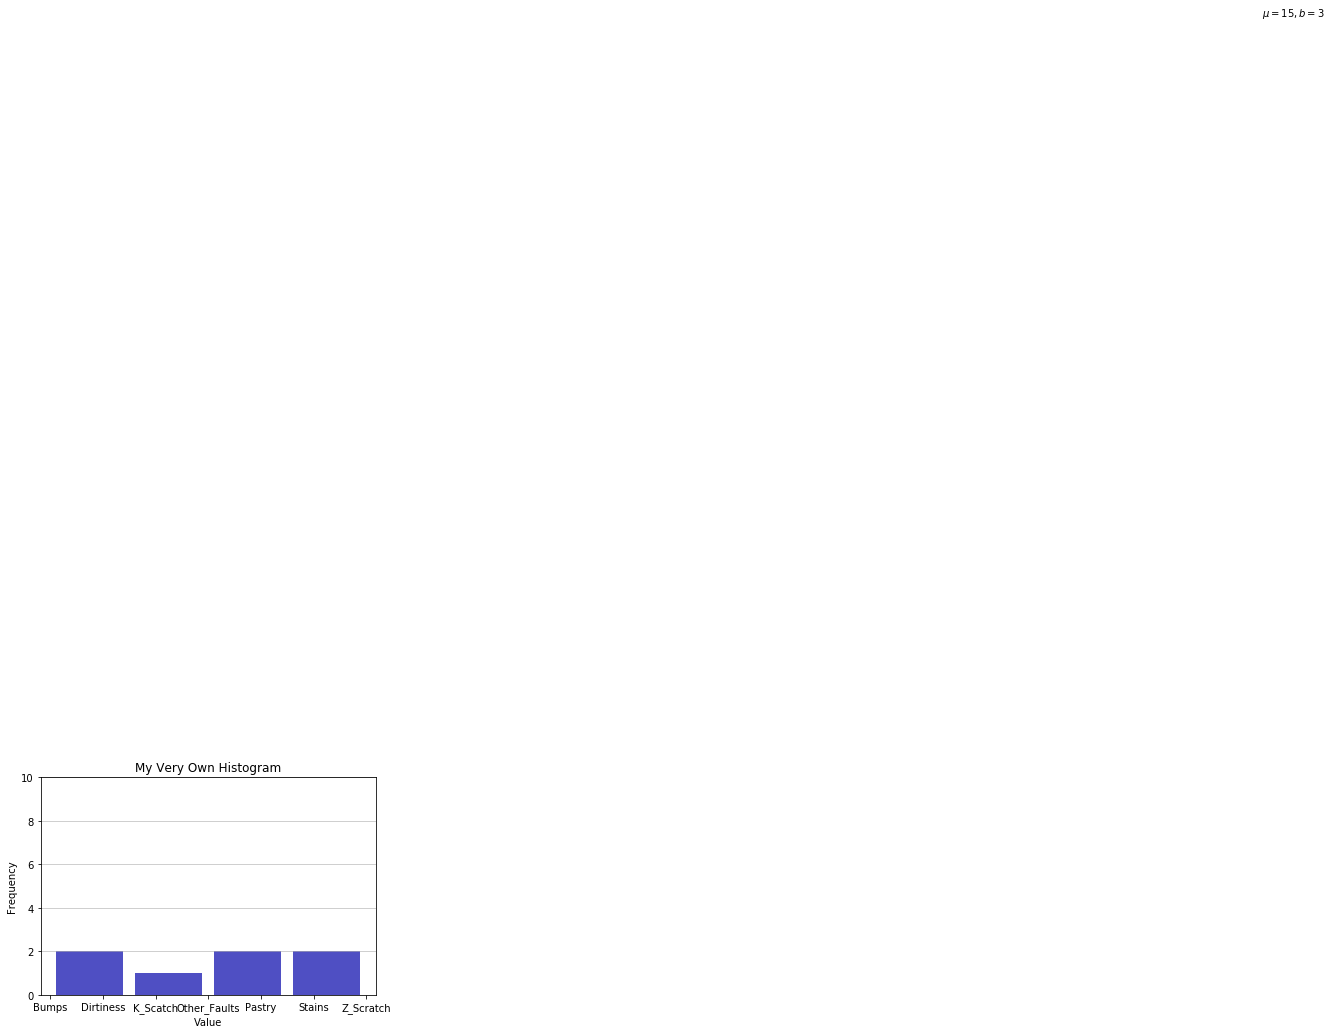

In [21]:

for name in Class_names:
    a = df[[name]]
    num_class = sum(sum(np.asarray(df[[name]])))
    print('Number of plates with defect '+ name + ' is ' + str(num_class))


df['Class_names'][:7]
df['Class_names'].value_counts()
df['Class_names'].value_counts().plot()




This dataset is unbalanced which means using the data as it is might result in unwanted behaviour from a supervised classifier.
To make it easy to understand if a classifier were to train with this data set trying to achieve the best accuracy possible it would most likely label every transaction as a non-fraud

To answer this problem we could use the oversampling principle or the undersampling principle
The undersampling principle should be used only if we can be sure that the selected few tuples (in this case non-fraud) are representative of the whole non-fraud transactions of the dataset.

# Correlation of features

In [9]:
df_corr = df.corr() # Calculation of the correlation coefficients in pairs, with the default method:
                    # Pearson, Standard Correlation Coefficient

In [10]:
plt.figure(figsize=(15,10))
seaborn.heatmap(df_corr, cmap="YlGnBu") # Displaying the Heatmap
seaborn.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

As we can notice, most of the features are not correlated with each other. This corroborates the fact that a PCA was previously performed on the data.

What can generally be done on a massive dataset is a dimension reduction.
By picking th emost important dimensions, there is a possiblity of explaining most of the problem, thus gaining
a considerable amount of time while preventing the accuracy to drop too much.

However in this case given the fact that a PCA was previously performed, if the dimension reduction is effective then the PCA wasn't computed in the most effective way. Another way to put it is that no dimension reduction should be computed on a dataset on which a PCA was computed correctly.

In [11]:
rank = df_corr['Class'] # Retrieving the correlation coefficients per feature in relation to the feature class
df_rank = pd.DataFrame(rank) 
df_rank = np.abs(df_rank).sort_values(by='Class',ascending=False) # Ranking the absolute values of the coefficients
                                                                  # in descending order
df_rank.dropna(inplace=True) # Removing Missing Data (not a number)

# Data Selection

OVERSAMPLING

One way to do oversampling is to replicate the under-represented class tuples until we attain a correct proportion between the class

However as we haven't infinite time nor the patience, we are going to run the classifier with the undersampled training data (for those using the undersampling principle if results are really bad just rerun the training dataset definition)

UNDERSAMPLING

In [12]:
# We seperate ours data in two groups : a train dataset and a test dataset

# First we build our train dataset
df_train_all = df[0:150000] # We cut in two the original dataset
df_train_1 = df_train_all[df_train_all['Class'] == 1] # We seperate the data which are the frauds and the no frauds
df_train_0 = df_train_all[df_train_all['Class'] == 0]
print('In this dataset, we have ' + str(len(df_train_1)) +" frauds so we need to take a similar number of non-fraud")

df_sample=df_train_0.sample(300)
df_train = df_train_1.append(df_sample) # We gather the frauds with the no frauds. 
df_train = df_train.sample(frac=1) # Then we mix our dataset

In [13]:
X_train = df_train.drop(['Time', 'Class'],axis=1) # We drop the features Time (useless), and the Class (label)
y_train = df_train['Class'] # We create our label
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [14]:
############################## with all the test dataset to see if the model learn correctly ##################
df_test_all = df[150000:]

X_test_all = df_test_all.drop(['Time', 'Class'],axis=1)
y_test_all = df_test_all['Class']
X_test_all = np.asarray(X_test_all)
y_test_all = np.asarray(y_test_all)

Then we define training and testing set after applying a dimension reduction to illustrate the fact that nothing will be gained because a PCA was previously computed

In [15]:
X_train_rank = df_train[df_rank.index[1:11]] # We take the first ten ranked features
X_train_rank = np.asarray(X_train_rank)

In [16]:
############################## with all the test dataset to see if the model learn correctly ##################
X_test_all_rank = df_test_all[df_rank.index[1:11]]
X_test_all_rank = np.asarray(X_test_all_rank)
y_test_all = np.asarray(y_test_all)

# Confusion Matrix

In [17]:
class_names=np.array(['0','1']) # Binary label, Class = 1 (fraud) and Class = 0 (no fraud)

In [18]:
# Function to plot the confusion Matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Model Selection

So now, we'll use a SVM model classifier, with the scikit-learn library.

In [19]:
classifier = svm.SVC(kernel='linear') # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)

In [20]:
classifier.fit(X_train, y_train) # Then we train our model, with our balanced data train.

# Testing the model

In [21]:
prediction_SVM_all = classifier.predict(X_test_all) #And finally, we predict our data test.

In [22]:
cm = confusion_matrix(y_test_all, prediction_SVM_all)
plot_confusion_matrix(cm,class_names)

In this case we are gonna try to minimize the number of errors in our prediction results. Errors are on the anti-diagonal of the confusion matrix.  But we can infer that being wrong about an actual fraud is far worse than being wrong about a non-fraud transaction. 

That is why  using the accuracy as only classification criterion could be considered unthoughtful. 
During the remaining part of this study our criterion will consider precision on the real fraud 4 times more important than the general accuracy.
Even though the final tested result is accuracy.

In [23]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

In [24]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

 # Models Rank

There is a need to compute the fit method again, as the dimension of the tuples to predict went from 29 to 10 because of the dimension reduction

In [25]:
classifier.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier.predict(X_test_all_rank) #And finally, we predict our data test.

In [26]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

In [27]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

In [28]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We can see that the study using the reduced data is far from unrelevant, which means that the last step of the previously computed PCA could have been done in a more efficient way. Indeed one of the main question we have with the PCA once we calculated the principals components direction, is how many of this component are we gonna keep. This means that some of the 30 dimensions are do not discriminate classes that much.

# Re-balanced class weigh :

In this previously used SVM model, the weigh of each class was the same, which means that missing a fraud is as bad as misjudging a non-fraud. The objective, for a bank, is to maximize the number of detected frauds! Even if it means considering more non-fraud tuple as fraudulent operation. So, we need to minimize the False positives : the number of no detected frauds.

Indeed, by modifying the class_weight parameter, we can chose which class to give more importance during the training phase. In this case, the class_1 which describes the fraudulent operations will be considered more important than the class_0 (non-fraud operation). However, in this case we will give more importance to the class_0 due to the large number of misclassed non-fraud operation. Of course the goal is to lose as little effective fraud as possible in the process.


In [29]:
classifier_b = svm.SVC(kernel='linear',class_weight={0:0.60, 1:0.40})

In [30]:
classifier_b.fit(X_train, y_train) # Then we train our model, with our balanced data train.

# Testing the model

In [31]:
prediction_SVM_b_all = classifier_b.predict(X_test_all) #We predict all the data set.

In [32]:
cm = confusion_matrix(y_test_all, prediction_SVM_b_all)
plot_confusion_matrix(cm,class_names)

In [33]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

In [34]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

 # Models Rank

In [35]:
classifier_b.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier_b.predict(X_test_all_rank) #And finally, we predict our data test.

In [36]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

In [37]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

In [38]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))